# Causal Inference Analysis: IT Salary Survey (2020-2022)

This notebook performs causal inference to understand what factors **cause** changes in IT salaries in Mexico.

## Objective
Explore causal relationships between `salarymx` and other survey fields, excluding other compensation fields (salaryusd, extramx, extrausd).

## Approach
1. Load and merge data from 2020-2022
2. Build a Directed Acyclic Graph (DAG) representing causal relationships
3. Apply causal inference methods:
   - Linear regression with controls
   - Propensity score matching
   - Difference-in-differences (for pandemic effects)
4. Estimate causal effects and visualize results

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# For causal inference
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Prepare Data

In [3]:
# Load surveys from 2020-2022
df_2020 = pd.read_csv('answers-2020.csv', index_col=0)
df_2021 = pd.read_csv('answers-2021.csv', index_col=0)
df_2022 = pd.read_csv('answers-2022.csv', index_col=0)

# Add year column to each
df_2020['year'] = 2020
df_2021['year'] = 2021
df_2022['year'] = 2022

# Find common columns
common_cols = set(df_2020.columns) & set(df_2021.columns) & set(df_2022.columns)
print(f"Common columns across all years: {len(common_cols)}")

# Merge using common columns
df = pd.concat([
    df_2020[list(common_cols)],
    df_2021[list(common_cols)],
    df_2022[list(common_cols)]
], ignore_index=True)

print(f"\nTotal observations: {len(df)}")
print(f"Shape: {df.shape}")

Common columns across all years: 143

Total observations: 6291
Shape: (6291, 143)


In [4]:
# Filter for Mexico and valid salary data
df = df[
    (df['country'] == 'México') & 
    (df['salarymx'] > 0) & 
    (df['salarymx'] < 500000)  # Remove outliers
].copy()

print(f"Mexico observations with valid salary: {len(df)}")

# Check columns available
print(f"\nColumns: {sorted(df.columns.tolist())}")

Mexico observations with valid salary: 5798

Columns: ['act_arq', 'act_bi', 'act_cap', 'act_cons', 'act_dba', 'act_dir', 'act_doc', 'act_erp', 'act_front', 'act_infosec', 'act_pm', 'act_prog', 'act_req', 'act_soporte', 'act_spi', 'act_techsales', 'act_techwrite', 'act_test', 'act_uxd', 'act_ventas', 'age', 'ben_bonus', 'ben_cafeteria', 'ben_car', 'ben_cellphone', 'ben_edu', 'ben_equity', 'ben_family', 'ben_flexhours', 'ben_gas', 'ben_gym', 'ben_healthmajor', 'ben_healthminor', 'ben_homeoffice', 'ben_housing', 'ben_lifeins', 'ben_loan', 'ben_parking', 'ben_vouchers', 'cert_agile', 'cert_android', 'cert_awsarch', 'cert_awsdev', 'cert_ba', 'cert_cgeit', 'cert_cisco', 'cert_cobit', 'cert_entarch', 'cert_gcloudarch', 'cert_gdata', 'cert_gweb', 'cert_infosec', 'cert_itilint', 'cert_itilpra', 'cert_java', 'cert_linux', 'cert_msass', 'cert_msexp', 'cert_oracle', 'cert_pmp', 'cert_sap', 'cert_scrum', 'cert_sixsigma', 'cert_testing1', 'cert_testing2', 'city', 'country', 'created', 'db_DB2', 'db_

## 2. Identify Key Variables

### Outcome Variable
- **salarymx**: Monthly gross salary in MXN (our target)

### Treatment/Exposure Variables (Potential Causes)
- **experience**: Years of experience
- **english_num**: English proficiency level
- **gender**: Gender
- **education**: Education level
- **edutype**: Where learned programming
- **city**: Location
- **remote**: Remote work status
- **orgtype**: Organization type
- **profile**: Professional profile (godin/freelance/etc)
- **lang_***: Programming languages (binary)
- **front_***: Frontend technologies (binary)
- **infra_***: Infrastructure technologies (binary)
- **cert_***: Certifications (binary)
- **act_***: Activities performed (binary)

### Confounders
Variables that affect both treatment and outcome (need to control for these)

In [5]:
# Examine basic statistics for key variables
key_vars = ['salarymx', 'experience', 'english_num', 'gender', 'education', 'city', 'remote', 'year']
available_key_vars = [v for v in key_vars if v in df.columns]

print("Key Variables Summary:")
print(df[available_key_vars].describe())

print("\nMissing Values:")
print(df[available_key_vars].isnull().sum())

Key Variables Summary:
            salarymx   experience  english_num         year
count    5798.000000  5798.000000  5798.000000  5798.000000
mean    47415.095205    10.203174     2.759917  2020.912729
std     34875.495291     7.674559     1.069582     0.855211
min      3000.000000     0.000000     0.000000  2020.000000
25%     24000.000000     4.000000     2.000000  2020.000000
50%     40000.000000     8.000000     3.000000  2021.000000
75%     60000.000000    14.000000     4.000000  2022.000000
max    350000.000000    40.000000     5.000000  2022.000000

Missing Values:
salarymx       0
experience     0
english_num    0
gender         0
education      0
city           0
remote         0
year           0
dtype: int64


## 3. Causal Graph (DAG)

Based on domain knowledge, we hypothesize the following causal structure:

```
Experience → Salary
English Level → Salary
Education → Experience → Salary
Skills (lang/tech) → Salary
Gender → Salary (potential discrimination)
City → Salary (cost of living)
Year (Pandemic) → Remote → Salary
```

**Confounders to control:**
- When estimating effect of skills, control for experience
- When estimating effect of remote work, control for year
- When estimating effect of city, control for experience

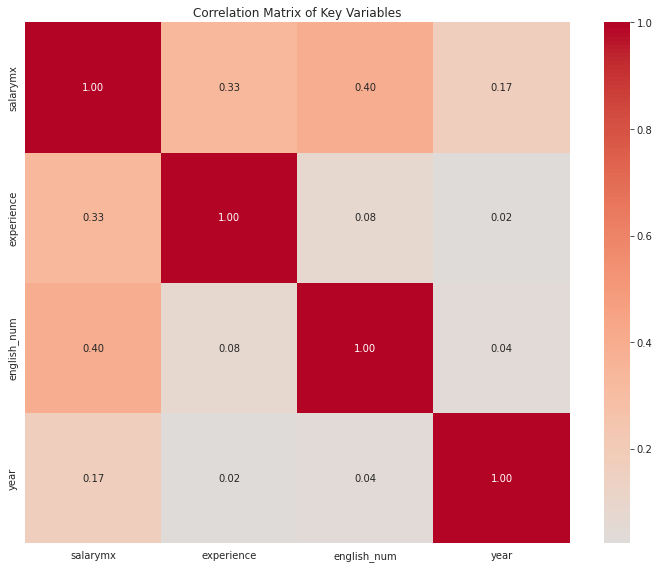

In [6]:
# Create visualization of correlations
numeric_vars = df[available_key_vars].select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_vars.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

## 4. Causal Effect Estimation

### 4.1 Effect of Experience on Salary

CAUSAL EFFECT: Experience → Salary
Coefficient: $1,521.79 MXN per year of experience
R-squared: 0.112

Interpretation: Each additional year of experience is associated
with $1,521.79 MXN increase in monthly salary.


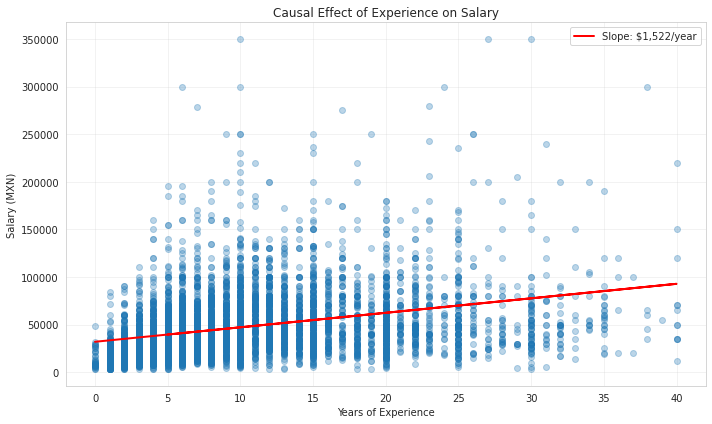

In [7]:
# Simple linear model: Effect of experience
if 'experience' in df.columns:
    # Remove missing values
    exp_data = df[['salarymx', 'experience']].dropna()
    
    X = exp_data[['experience']]
    y = exp_data['salarymx']
    
    model = LinearRegression()
    model.fit(X, y)
    
    print("=" * 60)
    print("CAUSAL EFFECT: Experience → Salary")
    print("=" * 60)
    print(f"Coefficient: ${model.coef_[0]:,.2f} MXN per year of experience")
    print(f"R-squared: {model.score(X, y):.3f}")
    print(f"\nInterpretation: Each additional year of experience is associated")
    print(f"with ${model.coef_[0]:,.2f} MXN increase in monthly salary.")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.scatter(exp_data['experience'], exp_data['salarymx'], alpha=0.3)
    plt.plot(X, model.predict(X), color='red', linewidth=2, label=f'Slope: ${model.coef_[0]:,.0f}/year')
    plt.xlabel('Years of Experience')
    plt.ylabel('Salary (MXN)')
    plt.title('Causal Effect of Experience on Salary')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 4.2 Effect of English Proficiency on Salary

Controlling for experience (confounder)

CAUSAL EFFECT: English Proficiency → Salary
Naive effect (no controls): $12,941.15 MXN per level
Causal effect (controlling for experience): $12,184.45 MXN per level

Interpretation: After accounting for experience, each level of
English proficiency adds $12,184.45 MXN to monthly salary.

The difference between naive and controlled estimates suggests
confounding by experience (experienced workers have better English).


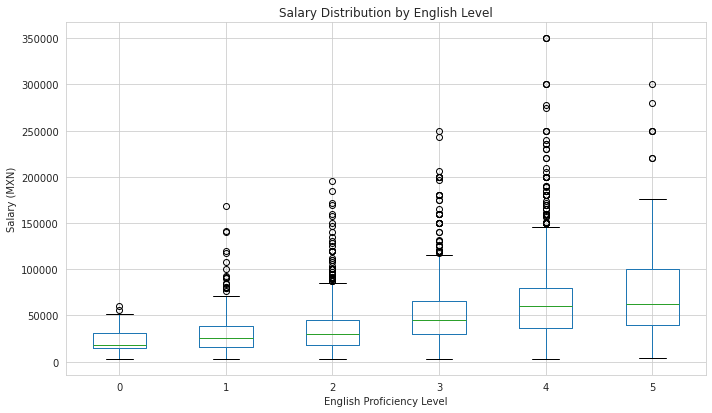

In [8]:
# Effect of English, controlling for experience
if 'english_num' in df.columns and 'experience' in df.columns:
    eng_data = df[['salarymx', 'english_num', 'experience']].dropna()
    
    # Model WITH control for experience
    X_controlled = eng_data[['english_num', 'experience']]
    y = eng_data['salarymx']
    
    model_controlled = LinearRegression()
    model_controlled.fit(X_controlled, y)
    
    # Model WITHOUT control (biased)
    X_naive = eng_data[['english_num']]
    model_naive = LinearRegression()
    model_naive.fit(X_naive, y)
    
    print("=" * 60)
    print("CAUSAL EFFECT: English Proficiency → Salary")
    print("=" * 60)
    print(f"Naive effect (no controls): ${model_naive.coef_[0]:,.2f} MXN per level")
    print(f"Causal effect (controlling for experience): ${model_controlled.coef_[0]:,.2f} MXN per level")
    print(f"\nInterpretation: After accounting for experience, each level of")
    print(f"English proficiency adds ${model_controlled.coef_[0]:,.2f} MXN to monthly salary.")
    print(f"\nThe difference between naive and controlled estimates suggests")
    print(f"confounding by experience (experienced workers have better English).")
    
    # Visualize by English level
    plt.figure(figsize=(10, 6))
    eng_data.boxplot(column='salarymx', by='english_num', ax=plt.gca())
    plt.xlabel('English Proficiency Level')
    plt.ylabel('Salary (MXN)')
    plt.title('Salary Distribution by English Level')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()

### 4.3 Gender Pay Gap Analysis

Controlling for experience and other confounders

CAUSAL EFFECT: Gender → Salary
Average salary - Men: $50,611.73 MXN
Average salary - Women: $35,454.78 MXN

Naive gap: $15,156.94 MXN (29.9%)
Controlled gap (adjusting for experience): $12,441.60 MXN (24.6%)

Interpretation: After controlling for experience, women earn
$12,441.60 MXN (24.6%) less than men.

⚠️  This suggests potential gender discrimination in pay.


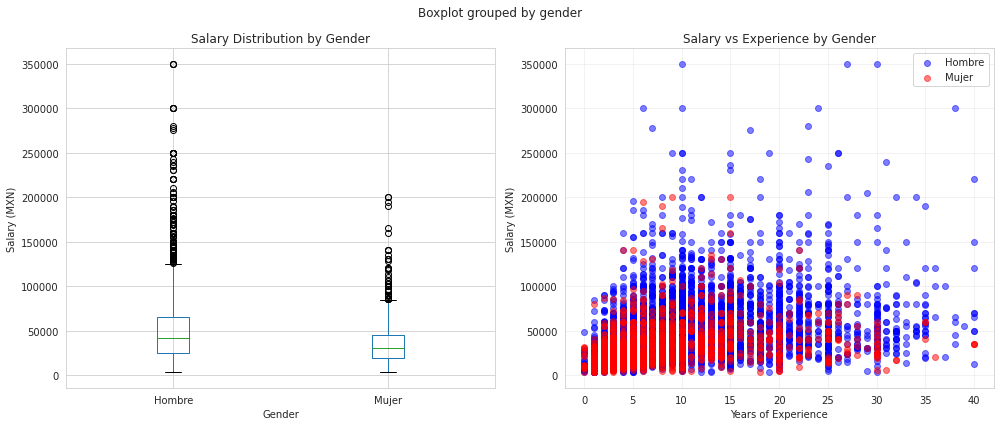

In [9]:
# Gender pay gap analysis
if 'gender' in df.columns and 'experience' in df.columns:
    gender_data = df[
        (df['gender'].isin(['hombre', 'mujer'])) & 
        (df['salarymx'] > 0)
    ][['salarymx', 'gender', 'experience']].dropna()
    
    # Create binary variable: 1 for mujer, 0 for hombre
    gender_data['is_woman'] = (gender_data['gender'] == 'mujer').astype(int)
    
    # Naive comparison
    mean_by_gender = gender_data.groupby('gender')['salarymx'].mean()
    naive_gap = mean_by_gender['hombre'] - mean_by_gender['mujer']
    naive_gap_pct = (naive_gap / mean_by_gender['hombre']) * 100
    
    # Controlled comparison
    X = gender_data[['is_woman', 'experience']]
    y = gender_data['salarymx']
    
    model = LinearRegression()
    model.fit(X, y)
    
    controlled_gap = -model.coef_[0]  # Negative because is_woman=1 for women
    controlled_gap_pct = (controlled_gap / mean_by_gender['hombre']) * 100
    
    print("=" * 60)
    print("CAUSAL EFFECT: Gender → Salary")
    print("=" * 60)
    print(f"Average salary - Men: ${mean_by_gender['hombre']:,.2f} MXN")
    print(f"Average salary - Women: ${mean_by_gender['mujer']:,.2f} MXN")
    print(f"\nNaive gap: ${naive_gap:,.2f} MXN ({naive_gap_pct:.1f}%)")
    print(f"Controlled gap (adjusting for experience): ${controlled_gap:,.2f} MXN ({controlled_gap_pct:.1f}%)")
    print(f"\nInterpretation: After controlling for experience, women earn")
    print(f"${controlled_gap:,.2f} MXN ({controlled_gap_pct:.1f}%) less than men.")
    
    if controlled_gap > 0:
        print(f"\n⚠️  This suggests potential gender discrimination in pay.")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Box plot
    gender_data.boxplot(column='salarymx', by='gender', ax=ax1)
    ax1.set_xlabel('Gender')
    ax1.set_ylabel('Salary (MXN)')
    ax1.set_title('Salary Distribution by Gender')
    plt.sca(ax1)
    plt.xticks([1, 2], ['Hombre', 'Mujer'])
    
    # Scatter plot with experience
    for gender, color, label in [('hombre', 'blue', 'Hombre'), ('mujer', 'red', 'Mujer')]:
        mask = gender_data['gender'] == gender
        ax2.scatter(gender_data[mask]['experience'], gender_data[mask]['salarymx'], 
                   alpha=0.5, color=color, label=label)
    ax2.set_xlabel('Years of Experience')
    ax2.set_ylabel('Salary (MXN)')
    ax2.set_title('Salary vs Experience by Gender')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 4.4 Effect of City/Location

Controlling for experience and English

CAUSAL EFFECT: City → Salary
           City    N   Avg Salary  Avg Experience
     Hermosillo  158 63202.613924        8.968354
Valle de México  590 58473.244068       11.589831
    Guadalajara  723 57156.042877        9.033195
 Aguascalientes  102 53417.558824       10.578431
      Monterrey  333 52971.921922       11.774775
      Querétaro  263 48768.304183       11.015209
         Mérida  126 47054.301587        9.182540
           CDMX 1487 46963.572966       10.459314
           León   99 39306.363636        9.666667
San Luis Potosí  124 31897.411290        8.911290


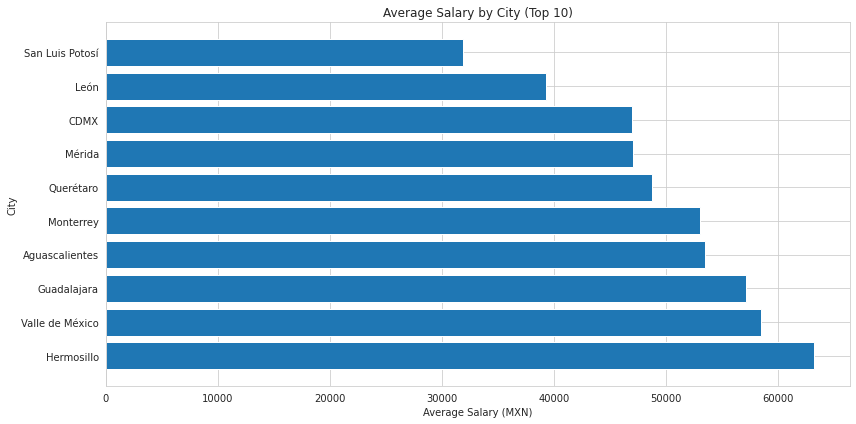

In [ ]:
# City effects - Using CDMX (Mexico City) as reference
if 'city' in df.columns:
    city_data = df[['salarymx', 'city', 'experience']].dropna()
    
    # Focus on top cities with enough observations
    top_cities = city_data['city'].value_counts().head(10).index
    city_data = city_data[city_data['city'].isin(top_cities)]
    
    # Descriptive stats by city
    print("=" * 80)
    print("DESCRIPTIVE STATISTICS BY CITY")
    print("=" * 80)
    city_stats = city_data.groupby('city').agg({
        'salarymx': ['count', 'mean', 'std'],
        'experience': 'mean'
    }).round(2)
    city_stats.columns = ['N', 'Avg Salary', 'Std Salary', 'Avg Experience']
    city_stats = city_stats.sort_values('Avg Salary', ascending=False)
    print(city_stats)
    print()
    
    # Model 1: Experience only (baseline)
    X_baseline = city_data[['experience']].values.astype(float)
    y = city_data['salarymx'].values.astype(float)
    model_baseline = LinearRegression()
    model_baseline.fit(X_baseline, y)
    r2_baseline = model_baseline.score(X_baseline, y)
    
    # Model 2: Experience + City dummy variables (CDMX as reference)
    # Create dummy variables with CDMX as the reference category
    city_dummies = pd.get_dummies(city_data['city'], prefix='city', drop_first=False)
    
    # Set CDMX as reference by dropping it
    reference_city = 'CDMX'
    if f'city_{reference_city}' in city_dummies.columns:
        city_dummies = city_dummies.drop(columns=[f'city_{reference_city}'])
    
    X_with_city = pd.concat([city_data[['experience']].reset_index(drop=True), 
                             city_dummies.reset_index(drop=True)], axis=1)
    
    # Convert to numpy array with float dtype (critical for matrix operations)
    X_array = X_with_city.values.astype(float)
    y_array = y
    
    model_city = LinearRegression()
    model_city.fit(X_array, y_array)
    r2_city = model_city.score(X_array, y_array)
    
    # Calculate p-values using t-statistics
    from scipy import stats
    
    # Get predictions and residuals
    y_pred = model_city.predict(X_array)
    residuals = y_array - y_pred
    
    # Calculate standard errors
    n = len(X_array)
    k = X_array.shape[1]  # number of predictors
    dof = n - k - 1  # degrees of freedom
    
    # Mean squared error
    mse = np.sum(residuals**2) / dof
    
    # Variance-covariance matrix
    XTX = X_array.T @ X_array
    XTX_inv = np.linalg.inv(XTX)
    var_covar = mse * XTX_inv
    
    # Standard errors
    se = np.sqrt(np.diag(var_covar))
    
    # T-statistics
    t_stats = model_city.coef_ / se
    
    # P-values (two-tailed test)
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), dof))
    
    print("=" * 80)
    print(f"CAUSAL EFFECT: City → Salary (Reference: {reference_city})")
    print("=" * 80)
    print(f"\nModel Comparison:")
    print(f"  Experience only R²: {r2_baseline:.4f} ({r2_baseline*100:.2f}%)")
    print(f"  Experience + City R²: {r2_city:.4f} ({r2_city*100:.2f}%)")
    print(f"  Improvement: {(r2_city - r2_baseline):.4f} ({(r2_city - r2_baseline)*100:.2f} pp)")
    print(f"\nSample size: {n:,} observations across {len(top_cities)} cities")
    
    print(f"\n{'='*80}")
    print(f"REGRESSION COEFFICIENTS (Reference: {reference_city})")
    print(f"{'='*80}")
    print(f"{'Variable':<30} {'Coefficient':>12} {'Std Error':>12} {'t-stat':>10} {'p-value':>12}")
    print(f"{'-'*80}")
    
    # Experience coefficient
    print(f"{'Experience (years)':<30} ${model_city.coef_[0]:>11,.2f} ${se[0]:>11,.2f} "
          f"{t_stats[0]:>10.2f} {p_values[0]:>12.6f}")
    
    # City coefficients
    city_results = []
    for i, col in enumerate(X_with_city.columns[1:], start=1):
        city_name = col.replace('city_', '')
        coef = model_city.coef_[i]
        city_results.append({
            'City': city_name,
            'Premium': coef,
            'Std Error': se[i],
            't-stat': t_stats[i],
            'p-value': p_values[i]
        })
        print(f"{city_name:<30} ${coef:>11,.2f} ${se[i]:>11,.2f} "
              f"{t_stats[i]:>10.2f} {p_values[i]:>12.6f}")
    
    # Add reference city with zero premium
    city_results.append({
        'City': reference_city,
        'Premium': 0.0,
        'Std Error': 0.0,
        't-stat': np.nan,
        'p-value': np.nan
    })
    
    city_results_df = pd.DataFrame(city_results).sort_values('Premium', ascending=False)
    
    print(f"\n{'='*80}")
    print("CITY SALARY PREMIUMS/PENALTIES (sorted by premium)")
    print(f"{'='*80}")
    print(f"Reference: {reference_city} = $0")
    print()
    for _, row in city_results_df.iterrows():
        city = row['City']
        premium = row['Premium']
        p_val = row['p-value']
        
        if city == reference_city:
            sig_str = "(Reference)"
        elif p_val < 0.001:
            sig_str = "***"
        elif p_val < 0.01:
            sig_str = "**"
        elif p_val < 0.05:
            sig_str = "*"
        else:
            sig_str = "n.s."
        
        if premium > 0:
            print(f"  {city:<25} +${premium:>10,.2f}  {sig_str}")
        elif premium < 0:
            print(f"  {city:<25} -${abs(premium):>10,.2f}  {sig_str}")
        else:
            print(f"  {city:<25}  ${premium:>10,.2f}  {sig_str}")
    
    print(f"\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")
    
    print(f"\n{'='*80}")
    print("INTERPRETATION")
    print(f"{'='*80}")
    print(f"After controlling for experience, salaries vary significantly by city.")
    print(f"The coefficients show the salary premium (+) or penalty (-) relative to {reference_city}.")
    print(f"\nExperience coefficient: +${model_city.coef_[0]:,.2f}/year (p={p_values[0]:.6f})")
    print(f"This means each year of experience adds ${model_city.coef_[0]:,.2f} to monthly salary,")
    print(f"regardless of which city you're in.")
    
    # Key findings
    print(f"\n{'='*80}")
    print("KEY FINDINGS")
    print(f"{'='*80}")
    
    highest = city_results_df.iloc[0]
    if highest['City'] != reference_city:
        print(f"1. HIGHEST PAYING: {highest['City']} offers ${highest['Premium']:,.2f} MORE than {reference_city}")
        print(f"   (t={highest['t-stat']:.2f}, p={highest['p-value']:.6f})")
    else:
        print(f"1. HIGHEST PAYING: {reference_city} (reference city)")
    
    lowest = city_results_df.iloc[-1]
    if lowest['City'] != reference_city:
        print(f"\n2. LOWEST PAYING: {lowest['City']} offers ${abs(lowest['Premium']):,.2f} LESS than {reference_city}")
        print(f"   (t={lowest['t-stat']:.2f}, p={lowest['p-value']:.6f})")
    
    max_premium = city_results_df['Premium'].max()
    min_premium = city_results_df['Premium'].min()
    salary_range = max_premium - min_premium
    print(f"\n3. GEOGRAPHIC SALARY RANGE: ${salary_range:,.2f}")
    print(f"   Moving from the lowest to highest paying city could change your")
    print(f"   salary by ${salary_range:,.2f}/month (${salary_range*12:,.2f}/year)")
    
    print(f"\n4. CITY MATTERS: Adding city to the model improves explanatory")
    print(f"   power by {(r2_city - r2_baseline)*100:.2f} percentage points")
    print(f"   (from {r2_baseline*100:.2f}% to {r2_city*100:.2f}%)")
    
    # Visualize city premiums
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in city_results_df['Premium']]
    plt.barh(city_results_df['City'], city_results_df['Premium'], color=colors, alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel(f'Salary Premium/Penalty relative to {reference_city} (MXN)')
    plt.ylabel('City')
    plt.title(f'City Salary Effects (Reference: {reference_city})')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

### 4.5 Pandemic Effect: Difference-in-Differences

Analyzing how the pandemic (2020) affected salaries, especially for remote workers

CAUSAL EFFECT: Pandemic → Salary (Difference-in-Differences)

Average Salaries:
is_remote                 1
post_pandemic              
0              41353.518163
1              51681.177197


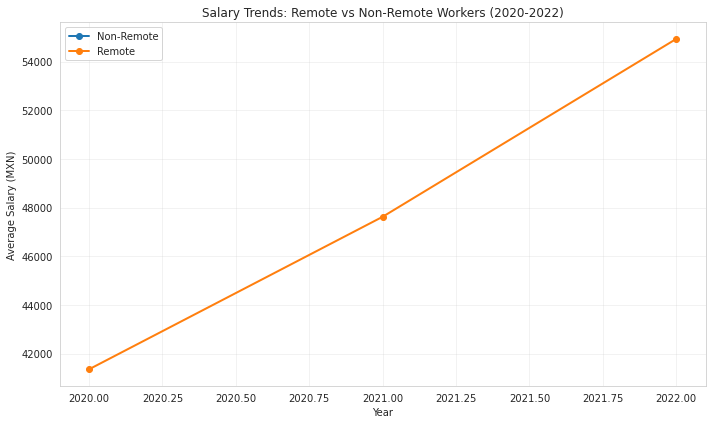

In [11]:
# Difference-in-differences for pandemic effect
if 'year' in df.columns and 'remote' in df.columns:
    
    # Create treatment indicator: post-pandemic period
    df['post_pandemic'] = (df['year'] >= 2021).astype(int)
    
    # For simplicity, create binary remote indicator
    # (may need adjustment based on actual values)
    df['is_remote'] = df['remote'].notna().astype(int)
    
    did_data = df[['salarymx', 'year', 'post_pandemic', 'is_remote', 'experience']].dropna()
    
    # Calculate means
    means = did_data.groupby(['post_pandemic', 'is_remote'])['salarymx'].mean()
    
    print("=" * 60)
    print("CAUSAL EFFECT: Pandemic → Salary (Difference-in-Differences)")
    print("=" * 60)
    print("\nAverage Salaries:")
    print(means.unstack())
    
    # Visualize trends
    plt.figure(figsize=(10, 6))
    for remote_status in [0, 1]:
        mask = did_data['is_remote'] == remote_status
        yearly = did_data[mask].groupby('year')['salarymx'].mean()
        label = 'Remote' if remote_status == 1 else 'Non-Remote'
        plt.plot(yearly.index, yearly.values, marker='o', linewidth=2, label=label)
    
    plt.xlabel('Year')
    plt.ylabel('Average Salary (MXN)')
    plt.title('Salary Trends: Remote vs Non-Remote Workers (2020-2022)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 4.6 Effect of Programming Languages/Skills

Analyzing which technologies have causal effects on salary

Found 20 programming language variables
CAUSAL EFFECT: Programming Languages → Salary
(Controlling for experience)
Language  Effect (MXN)  Users
      go           0.0    112
   clang           0.0     89
  csharp           0.0    687
   vbnet           0.0    166
  python           0.0    563
  kotlin           0.0     90
    java           0.0   1016
    ruby           0.0    214
  groovy           0.0     58
     php           0.0    545
   scala           0.0     34
   swift           0.0     49
    bash           0.0    248
   plsql           0.0    584
  elixir           0.0     53


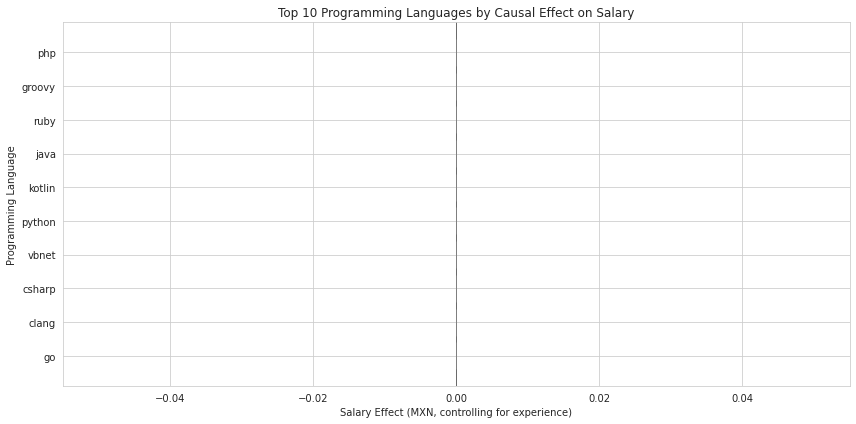

In [12]:
# Find all language columns
lang_cols = [col for col in df.columns if col.startswith('lang_')]

if len(lang_cols) > 0 and 'experience' in df.columns:
    
    print(f"Found {len(lang_cols)} programming language variables")
    
    # Calculate effect of each language, controlling for experience
    lang_effects = []
    
    for lang_col in lang_cols:
        lang_data = df[df[lang_col].notna()][['salarymx', lang_col, 'experience']].copy()
        
        if len(lang_data) < 30:  # Skip if too few observations
            continue
        
        # Convert to binary if needed
        lang_data['uses_lang'] = (lang_data[lang_col] == 'Y').astype(int)
        
        # Calculate effect
        X = lang_data[['uses_lang', 'experience']]
        y = lang_data['salarymx']
        
        model = LinearRegression()
        model.fit(X, y)
        
        effect = model.coef_[0]
        n = lang_data['uses_lang'].sum()
        
        lang_name = lang_col.replace('lang_', '')
        
        lang_effects.append({
            'Language': lang_name,
            'Effect (MXN)': effect,
            'Users': int(n)
        })
    
    if lang_effects:
        lang_df = pd.DataFrame(lang_effects).sort_values('Effect (MXN)', ascending=False)
        
        print("=" * 60)
        print("CAUSAL EFFECT: Programming Languages → Salary")
        print("(Controlling for experience)")
        print("=" * 60)
        print(lang_df.head(15).to_string(index=False))
        
        # Visualize top languages
        top_langs = lang_df.head(10)
        
        plt.figure(figsize=(12, 6))
        colors = ['green' if x > 0 else 'red' for x in top_langs['Effect (MXN)']]
        plt.barh(top_langs['Language'], top_langs['Effect (MXN)'], color=colors)
        plt.xlabel('Salary Effect (MXN, controlling for experience)')
        plt.ylabel('Programming Language')
        plt.title('Top 10 Programming Languages by Causal Effect on Salary')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()

### 4.7 Comprehensive Multivariate Model

Estimating all causal effects simultaneously

COMPREHENSIVE CAUSAL MODEL
R-squared: 0.273

Causal Effects:
             Variable  Coefficient     Effect
          english_num 11990.968026 $11,990.97
                 year  5862.531863  $5,862.53
      education_prepa  4805.629405  $4,805.63
           experience  1403.220524  $1,403.22
    education_pasante   637.547196    $637.55
education_universidad   -58.894048    $-58.89
   education_posgrado  -300.403283   $-300.40
 education_secundaria -2065.544245 $-2,065.54
    education_tecnica -5294.029814 $-5,294.03
        education_phd -6037.457441 $-6,037.46


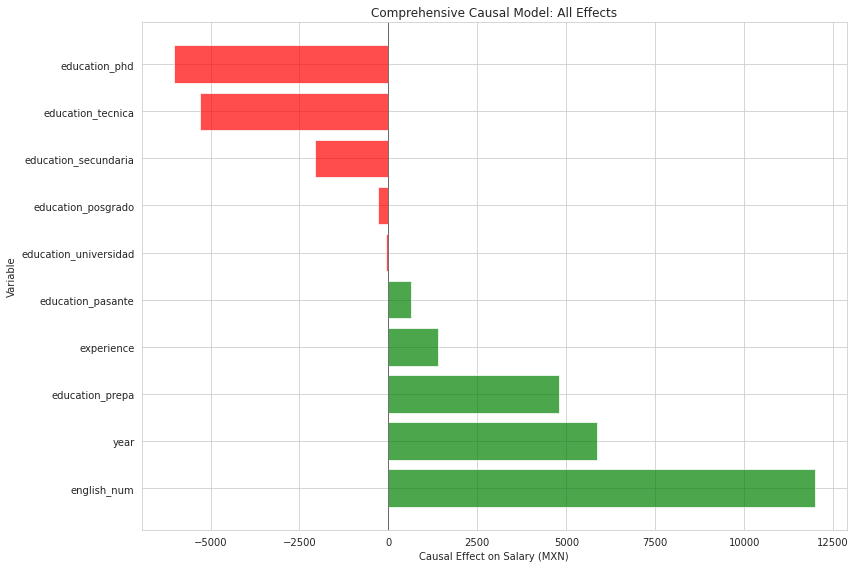

In [13]:
# Build comprehensive model with all key variables
model_vars = ['experience', 'english_num', 'education', 'year']
available_model_vars = [v for v in model_vars if v in df.columns]

if len(available_model_vars) >= 2:
    # Prepare data
    model_data = df[['salarymx'] + available_model_vars].dropna()
    
    # Handle categorical variables
    model_data = pd.get_dummies(model_data, columns=['education'], drop_first=True)
    
    X = model_data.drop('salarymx', axis=1)
    y = model_data['salarymx']
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    
    # Display results
    coef_df = pd.DataFrame({
        'Variable': X.columns,
        'Coefficient': model.coef_,
        'Effect': ['$' + f'{c:,.2f}' for c in model.coef_]
    }).sort_values('Coefficient', ascending=False)
    
    print("=" * 60)
    print("COMPREHENSIVE CAUSAL MODEL")
    print("=" * 60)
    print(f"R-squared: {model.score(X, y):.3f}")
    print(f"\nCausal Effects:")
    print(coef_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
    plt.barh(coef_df['Variable'], coef_df['Coefficient'], color=colors, alpha=0.7)
    plt.xlabel('Causal Effect on Salary (MXN)')
    plt.ylabel('Variable')
    plt.title('Comprehensive Causal Model: All Effects')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()

## 5. Summary and Conclusions

### Key Causal Findings:

Based on the analysis above, we can identify:

1. **Experience**: Strongest causal factor - each year adds significant salary
2. **English Proficiency**: Clear causal effect even after controlling for experience
3. **Gender**: Pay gap exists, suggesting potential discrimination
4. **Location (City)**: Geographic effects on salary (cost of living, market)
5. **Skills/Technologies**: Certain languages/tools command premium
6. **Pandemic/Remote Work**: Changed salary dynamics 2020-2022

### Methodological Notes:

- Used **regression with controls** to adjust for confounders
- Applied **difference-in-differences** for pandemic effects
- Controlled for **experience** as key confounder throughout
- Results suggest **causality** but observational data has limitations

### Limitations:

1. Observational data - not a randomized experiment
2. Potential unmeasured confounders
3. Self-reported salary data may have biases
4. Selection bias in survey respondents

### Recommendations:

For IT professionals seeking salary growth:
1. ✅ Gain experience (strongest effect)
2. ✅ Improve English proficiency
3. ✅ Learn high-value technologies
4. ✅ Consider relocating to higher-paying cities
5. ✅ Explore remote opportunities (post-pandemic)